In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay
import os

In [9]:
df_raw = pd.read_csv("apachejit_total.csv")
df_raw.head()

,commit_id,project,buggy,fix,year,author_date,la,ld,nf,nd,ns,ent,ndev,age,nuc,aexp,arexp,asexp
0,7b8480744ea6e6fb41efd4329bb470c8f3c763db,apache/groovy,False,False,2003,1070355653,372,23,8,3,3,2.669743,0.250000,3.625000,2.125,243,243.0,0.683585
1,192b631e7be302ecde822546ba70a9853ddbda01,apache/groovy,False,False,2003,1063298262,2,2,2,2,1,1.000000,1.000000,0.000000,2.500,19,19.0,14.000000
2,0ab6465a7dece117c61c3efd3ec95d20524bdad6,apache/groovy,False,False,2003,1069704572,41,26,3,3,2,1.237612,0.666667,5.333333,45.000,233,233.0,0.000606
3,449241d5fa1aeadd5eb9fa1280d4104dc0dfb891,apache/groovy,False,False,2003,1068487625,8,6,2,1,1,0.591673,1.000000,3.000000,35.500,64,64.0,55.000000
4,698df9f5b0816e05bbf97a390428f8ef94e0cdbf,apache/groovy,False,False,2003,1063313516,70,4,6,3,1,2.519672,0.333333,0.000000,6.000,27,27.0,22.000000


In [10]:
missing_values = df_raw.isnull().sum()
print(missing_values)

commit_id      0
project        0
buggy          0
fix            0
year           0
author_date    0
la             0
ld             0
nf             0
nd             0
ns             0
ent            0
ndev           0
age            0
nuc            0
aexp           0
arexp          0
asexp          0
dtype: int64


In [11]:
df_processed = df_raw.dropna(subset=['la', 'ld', 'nf', 'buggy']).copy()

In [20]:
df_processed['code_churn'] = df_processed['la'] + df_processed['ld']

print(df_processed['code_churn'].head())

0    395
1      4
2     67
3     14
4     74
Name: code_churn, dtype: int64


In [21]:
features = ['la', 'ld', 'nf', 'code_churn']
target = 'buggy'

df_processed[target] = df_processed[target].astype(int)

X = df_processed[features]
y = df_processed[target]

print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")
print(X.head())
print(y.head())

Shape of X: (106674, 4), Shape of y: (106674,)
    la  ld  nf  code_churn
0  372  23   8         395
1    2   2   2           4
2   41  26   3          67
3    8   6   2          14
4   70   4   6          74
0    0
1    0
2    0
3    0
4    0
Name: buggy, dtype: int64


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test = X_test.to_numpy()
print("\n testing set")
print(X_test)


 testing set
[[ 4  0  2  4]
 [ 2  2  1  4]
 [ 9  9  2 18]
 ...
 [17 25  1 42]
 [61  8  4 69]
 [23 27  4 50]]


In [26]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

print("\nScaled training")
print(X_train_scaled[:5])
print("\nScaled testing")
print(X_test_scaled[:5])


Scaled training
[[-0.33321686 -0.21012715 -0.52951161 -0.35169313]
 [-0.07925378 -0.23925244 -0.43021153 -0.16908909]
 [ 0.00413708 -0.21336329 -0.33091145 -0.09312581]
 [-0.0072344  -0.24572473 -0.52951161 -0.11649913]
 [-0.34269309  0.41444866 -0.33091145 -0.07705666]]

Scaled testing
[[-0.34837883 -0.24572473 -0.43021153 -0.37944895]
 [-0.35216933 -0.23925244 -0.52951161 -0.37944895]
 [-0.3389026  -0.21659944 -0.43021153 -0.35899729]
 [-0.33132161 -0.24572473 -0.43021153 -0.36630146]
 [-0.35027408 -0.24248859 -0.52951161 -0.37944895]]


C:\Users\MSI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [27]:
#Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, class_weight='balanced', n_jobs=-1)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
print("\nRandom Forest Classifier")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:, 1]))


Random Forest Classifier
              precision    recall  f1-score   support

           0       0.82      0.77      0.80     15687
           1       0.46      0.54      0.50      5648

    accuracy                           0.71     21335
   macro avg       0.64      0.66      0.65     21335
weighted avg       0.73      0.71      0.72     21335

ROC AUC Score: 0.725807818937064


In [28]:
#Logistic Regression
lr = LogisticRegression(C=0.1, solver='liblinear', class_weight='balanced')
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
print("\nLogistic Regression")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC Score:", roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:, 1]))



Logistic Regression
              precision    recall  f1-score   support

           0       0.81      0.85      0.83     15687
           1       0.52      0.46      0.49      5648

    accuracy                           0.74     21335
   macro avg       0.67      0.65      0.66     21335
weighted avg       0.74      0.74      0.74     21335

ROC AUC Score: 0.7451146259574022


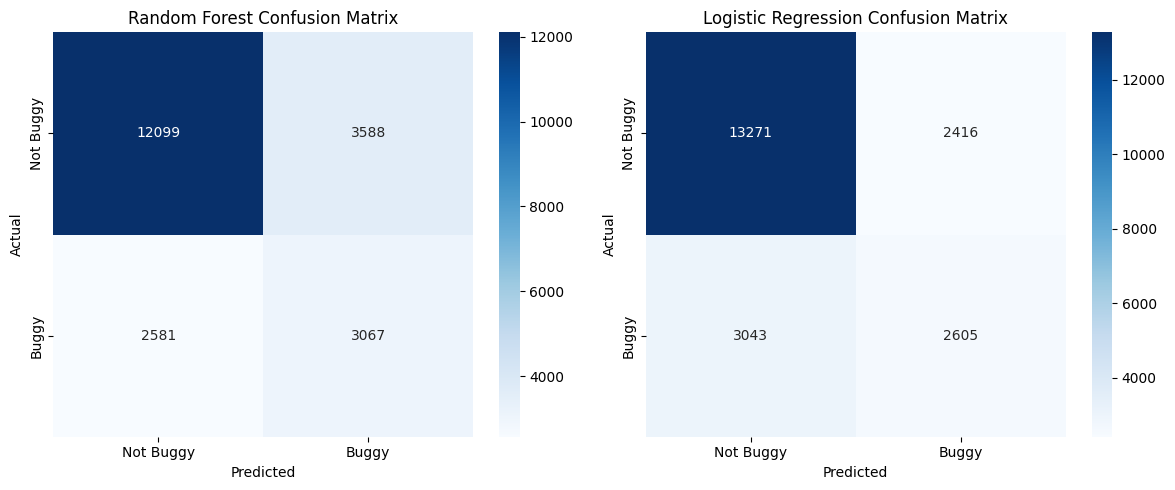

In [29]:
#confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Buggy', 'Buggy'], yticklabels=['Not Buggy', 'Buggy'])
plt.title('Random Forest Confusion Matrix') 
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(1, 2, 2)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Buggy', 'Buggy'], yticklabels=['Not Buggy', 'Buggy'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

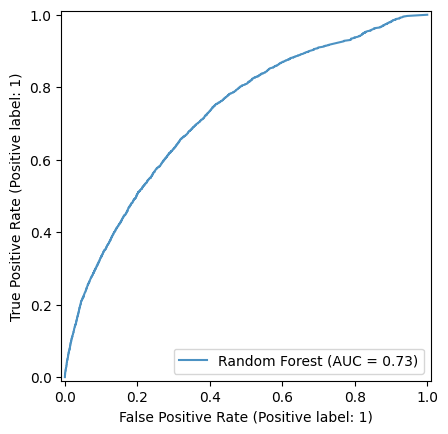

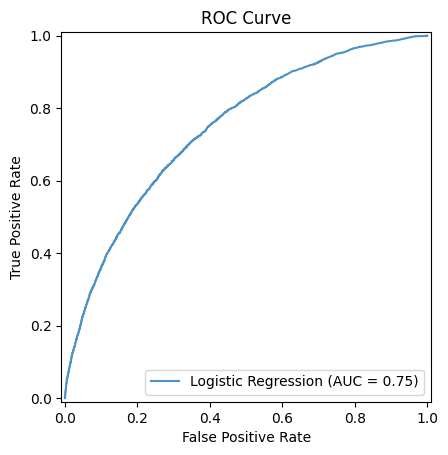

In [30]:
#ROC Curve
plt.figure(figsize=(10, 6))
RocCurveDisplay.from_estimator(rf, X_test_scaled, y_test, name='Random Forest', alpha=0.8)
RocCurveDisplay.from_estimator(lr, X_test_scaled, y_test, name='Logistic Regression', alpha=0.8)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

